## Try adding some metrics based on reasonable clustering before running the random forest.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [36]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

In [121]:
metrics=[ #"period",
         #"power",
         #"dur",
         #"depth",
         # "snr",
         "deptest1","deptest2",
         #"chisq",
         "bicft",
         #"bicplus",
         #"bicminus",
         "snrshape",
         #"noise",
         "depth_shape2",
         "depth_shape3",
         #"mindBIC"
         #"nloops",
         #"npoints","nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
#Using this just to create a random set for figuring out the clustering size.
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.85)

In [114]:
common_params = {
    "n_init": "auto"
}
for n in [2,4,10, 15,20,30]:
    kmeans_pred = KMeans(n_clusters=n, **common_params).fit_predict(X_train)

    sample_silhouette_values = silhouette_samples(X_train, kmeans_pred)
    print("Average Silhouette values for %u: %f" % (n, np.mean(sample_silhouette_values)))

Average Silhouette values for 2: 0.994101
Average Silhouette values for 4: 0.933224
Average Silhouette values for 10: 0.793677
Average Silhouette values for 15: 0.607786
Average Silhouette values for 20: 0.539314
Average Silhouette values for 30: 0.502223


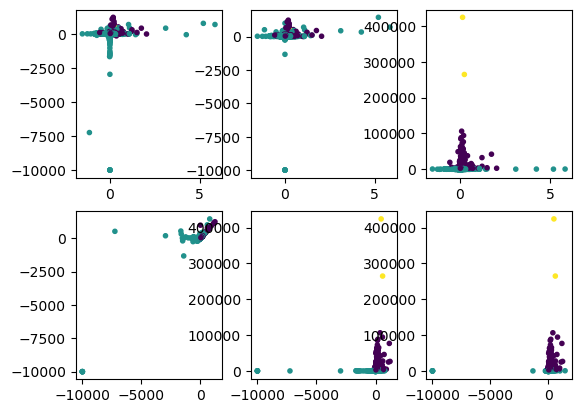

In [115]:
kmeans_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.figure()
plt.subplot(231)
plt.scatter(X[:,0],X[:,1],c=kmeans_pred,marker='.')
plt.subplot(232)
plt.scatter(X[:,0],X[:,2],c=kmeans_pred,marker='.')
plt.subplot(233)
plt.scatter(X[:,0],X[:,3],c=kmeans_pred,marker='.')
plt.subplot(234)
plt.scatter(X[:,1],X[:,2],c=kmeans_pred,marker='.')
plt.subplot(235)
plt.scatter(X[:,1],X[:,3],c=kmeans_pred,marker='.')
plt.subplot(236)
plt.scatter(X[:,2],X[:,3],c=kmeans_pred,marker='.')

## Random forest with new cluster parameter

In [116]:
tces['cluster1'] = kmeans_pred

metrics=[ #"period",
         #"power",
         "dur","depth",
         "snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise",
         "depth_shape2","depth_shape3",
         "mindBIC",
         "nloops",
         "npoints",
         "nintransit",
        "cluster1"
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.2)

In [117]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.989605


Accuracy: 0.9894092625547983


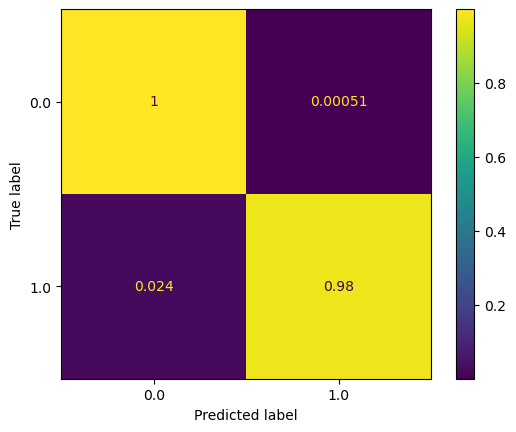

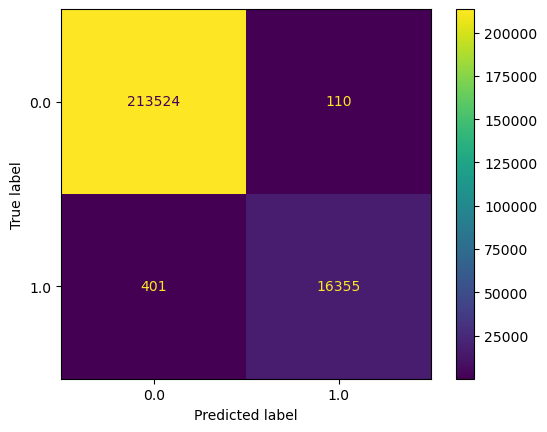

In [118]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

0.9925273943968367


(0.8, 1.0)

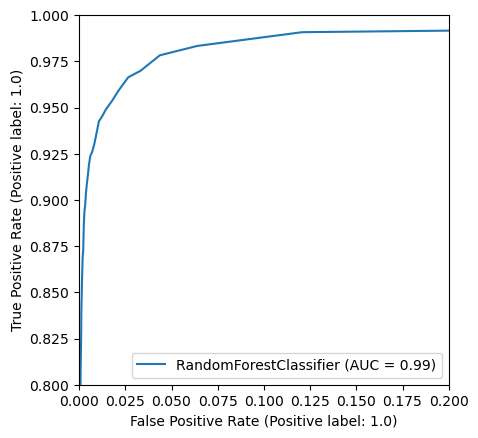

In [119]:
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
print(roc_auc_score(y_test, y_test_prob[:,1]))
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.xlim(0,.2)
plt.ylim(0.8,1)

In [120]:
## What sort of features are most important
isort = np.argsort(rf.feature_importances_)
for i,m in enumerate(metrics):
    print(m, 100*rf.feature_importances_[i])

dur 2.837120672542125
depth 3.272739660208905
snr 15.180635362151099
deptest1 4.8825820168871115
deptest2 4.145202353612674
chisq 5.089652553054811
bicft 4.8630068122376064
bicplus 1.7994883951280614
bicminus 1.2286727690139203
snrshape 10.961618760980455
noise 0.8483603623118755
depth_shape2 11.653653963298483
depth_shape3 22.25631814666884
mindBIC 5.3248237871918365
nloops 1.3900815317920017
npoints 1.1856419600112762
nintransit 3.072629836455589
cluster1 0.007771056453330422
